In [1]:
!pip install transformers datasets accelerate peft torch rouge-score bert-score nltk pandas scikit-learn bitsandbytes shap auto-gptq opacus
!pip install --upgrade peft

In [2]:
import nltk
from transformers import BitsAndBytesConfig, FbgemmFp8Config
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import AutoTokenizer, AutoModelForCausalLM, GPTQConfig
from auto_gptq import AutoGPTQForCausalLM
from transformers import pipeline
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import torch
import bitsandbytes as bnb
from transformers import TrainingArguments, Trainer
from opacus import PrivacyEngine
from torch import nn, optim
from datasets import load_dataset
import pandas as pd
import numpy as np
from transformers import AutoConfig
from torch.utils.data import DataLoader


In [3]:
from transformers import DataCollatorForLanguageModeling

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nltk.download('wordnet')
# Load medical abstract dataset
train_data = load_dataset('csv', data_files='medical_tc_train.csv', split='train')
test_data = load_dataset('csv', data_files='medical_tc_test.csv', split='train')
# Load Model & Tokenizer
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token  # Add padding token if necessary
def tokenize_function(examples):
    return tokenizer(
        examples['medical_abstract'], truncation=True, padding='max_length', max_length=128
    )
    return tokenized
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Tokenize dataset
train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

# Set format for PyTorch
train_data.set_format(type="torch", columns=["input_ids", "attention_mask"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask"])
# DataLoader
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=data_collator)
test_dataloader = DataLoader(test_data, batch_size=8, collate_fn=data_collator)

[nltk_data] Downloading package wordnet to C:\Users\my pc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
#model_name = "deepseek-ai/deepseek-coder-1.3b-base"
#model_name = "deepseek-ai/deepseek-V2.5-1210"
#model_name = "meta-llama/Llama-3.1-8B"
model_name = "meta-llama/Llama-3.2-1B"
#config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [5]:
torch.cuda.empty_cache()
# Define LoRA Configuration
lora_config = LoraConfig(
    r=8,               # LoRA rank
    lora_alpha=16,      # Scaling factor
    lora_dropout=0.3,   # Dropout rate
    target_modules=["q_proj", "v_proj"]  # Apply LoRA to attention layers
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [6]:
torch.cuda.empty_cache()
model.to(device)
# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
privacy_engine = PrivacyEngine()
sample_rate = 8 / len(train_data)  # Batch size / dataset size
model, optimizer, dataloader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    target_epsilon=10.0,
    target_delta=1e-5,    
    epochs=3,
    max_grad_norm=1.0,
)

/home/dgxuser49/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/dgxuser49/.local/lib/python3.8/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


In [7]:
torch.cuda.empty_cache()
model.to(device)
epochs = 3
for epoch in range(epochs):
    total_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        model.train()
        optimizer.zero_grad()        
        outputs = model(input_ids=input_ids, labels=input_ids)
        loss = outputs.loss        
        loss.backward()
        optimizer.step()      
        total_loss += loss.item()
        if step % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{step}], Loss: {loss.item():.4f}")  
        torch.cuda.empty_cache()    
    torch.cuda.empty_cache()
torch.cuda.empty_cache()

/home/dgxuser49/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch [1/3], Step [0], Loss: 2.0311
Epoch [1/3], Step [10], Loss: 2.1246
Epoch [1/3], Step [20], Loss: 3.6974
Epoch [1/3], Step [30], Loss: 2.9864
Epoch [1/3], Step [40], Loss: 2.0909
Epoch [1/3], Step [50], Loss: 2.1139
Epoch [1/3], Step [60], Loss: 2.7050
Epoch [1/3], Step [70], Loss: 3.7664
Epoch [1/3], Step [80], Loss: 2.2889
Epoch [1/3], Step [90], Loss: 3.0982
Epoch [1/3], Step [100], Loss: 2.7449
Epoch [1/3], Step [110], Loss: 2.1457
Epoch [1/3], Step [120], Loss: 2.1331
Epoch [1/3], Step [130], Loss: 2.2121
Epoch [1/3], Step [140], Loss: 2.2859
Epoch [1/3], Step [150], Loss: 2.4775
Epoch [1/3], Step [160], Loss: 2.0575
Epoch [1/3], Step [170], Loss: 2.3504
Epoch [1/3], Step [180], Loss: 2.3841
Epoch [1/3], Step [190], Loss: 3.1464
Epoch [1/3], Step [200], Loss: 2.2561
Epoch [1/3], Step [210], Loss: 1.9975
Epoch [1/3], Step [220], Loss: 2.3221
Epoch [1/3], Step [230], Loss: 3.2456
Epoch [1/3], Step [240], Loss: 2.2504
Epoch [1/3], Step [250], Loss: 2.5120
Epoch [1/3], Step [260]

In [9]:
# Save the LoRA-adapted model
def save_model(model, epoch, filename='lora_dp_medical_llama328.pth'):
    state_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict()
    }
    torch.save(state_dict, filename)
    print(f"Model saved to {filename}")  
model = model._module
save_model(model, epoch)

Model saved to lora_dp_medical_llama328.pth


In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

def load_model(model,filename='lora_dp_medical_llama328.pth'):
    checkpoint = torch.load(filename, map_location="cuda")

    # Resize model embeddings before loading state dict
    tokenizer_vocab_size = len(tokenizer)
    model_vocab_size = checkpoint["model_state_dict"]["base_model.model.model.embed_tokens.weight"].shape[0]
    
    if tokenizer_vocab_size != model_vocab_size:
        print(f"Resizing model embeddings: {model_vocab_size} → {tokenizer_vocab_size}")
        model.resize_token_embeddings(model_vocab_size)

    model.load_state_dict(checkpoint["model_state_dict"], strict=False)
    
    epoch = checkpoint["epoch"]
    print(f"Model loaded from {filename}")
    return model, epoch
generator_model, start_epoch = load_model(model)

print("Generator model loaded successfully!")

C:\Users\my pc\AppData\Local\Temp\ipykernel_6764\1202912694.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location="cuda")


Model loaded from lora_dp_medical_llama328.pth
Generator model loaded successfully!


In [11]:
!pip install rouge

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [7]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator_model = generator_model.to(device)
# Load the dataset
train_df = pd.read_csv("medical_tc_test.csv")
texts = train_df["medical_abstract"][:200].tolist()

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Create prompts from the first 50 words
prompts = [' '.join(str(text).split()[:50]) for text in texts]

def generate_long_text(model, tokenizer, prompt, max_length=300):    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text

def calculate_perplexity(model, tokenizer, text):
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Loop over prompts, generate text, and record perplexity scores
perplexity_scores = []
for i, prompt in enumerate(prompts):
    generated_text_str = generate_long_text(generator_model, tokenizer, prompt, max_length=300)
    perplexity = calculate_perplexity(generator_model, tokenizer, generated_text_str)
    perplexity_scores.append(perplexity)
    print(f"Sample {i}: Perplexity = {perplexity:.4f}")

# Save perplexity scores to a CSV file
df = pd.DataFrame({
    "Index": range(len(perplexity_scores)),
    "Perplexity": perplexity_scores
})
df.to_csv("lora_dp_med_llm32_perplexity_scores.csv", index=False)
print("Perplexity scores saved to perplexity_scores.csv")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Sample 0: Perplexity = 3.4402
Sample 1: Perplexity = 2.5866
Sample 2: Perplexity = 2.8166
Sample 3: Perplexity = 3.2004
Sample 4: Perplexity = 4.4227
Sample 5: Perplexity = 3.3087
Sample 6: Perplexity = 2.8027
Sample 7: Perplexity = 4.0231
Sample 8: Perplexity = 2.3739
Sample 9: Perplexity = 4.1105
Sample 10: Perplexity = 4.2021
Sample 11: Perplexity = 2.1621
Sample 12: Perplexity = 3.7700
Sample 13: Perplexity = 2.0665
Sample 14: Perplexity = 4.1341
Sample 15: Perplexity = 6.1420
Sample 16: Perplexity = 3.9825
Sample 17: Perplexity = 3.6846
Sample 18: Perplexity = 4.9728
Sample 19: Perplexity = 4.2174
Sample 20: Perplexity = 2.9683
Sample 21: Perplexity = 2.7167
Sample 22: Perplexity = 4.2280
Sample 23: Perplexity = 2.7209
Sample 24: Perplexity = 2.6443
Sample 25: Perplexity = 3.3746
Sample 26: Perplexity = 2.7279
Sample 27: Perplexity = 3.8531
Sample 28: Perplexity = 2.1696
Sample 29: Perplexity = 2.9298
Sample 30: Perplexity = 2.4968
Sample 31: Perplexity = 2.5748
Sample 32: Perplex

In [8]:
import numpy as np
np.mean(perplexity_scores)

3.6875418037176133

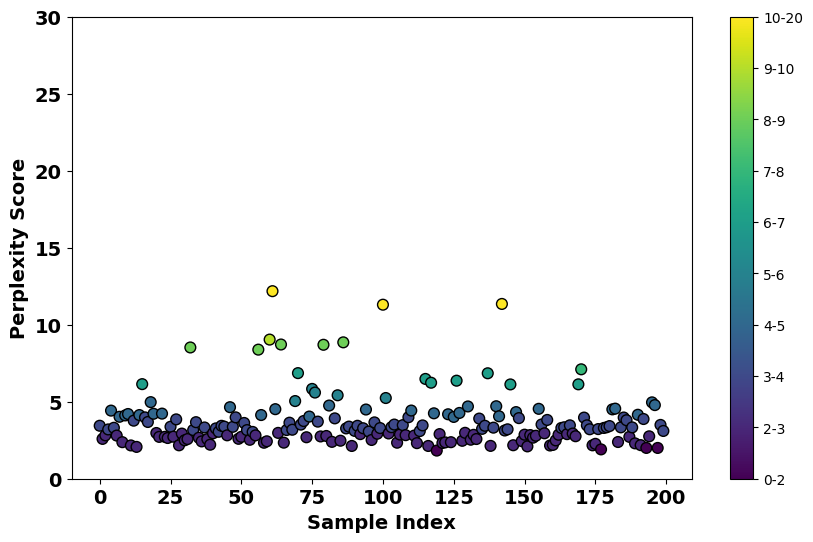

In [9]:
# Group perplexity scores into defined ranges.
# For this example, we group scores as: 0-20, 20-40, 40-60, 60-80, 80-100, and 100+
bins = [0,2,3,4,5,6,7,8,9,10,20, 40, 60, 80, 100, float('inf')]
labels = ["0-2", "2-3","3-4","4-5","5-6","6-7","7-8","8-9","9-10","10-20","20-40", "40-60", "60-80", "80-100", "100+"]
df["Perplexity Group"] = pd.cut(df["Perplexity"], bins=bins, labels=labels)

# Create a scatter plot of perplexity scores.
plt.figure(figsize=(10, 6))
# Color-code by perplexity group using categorical codes.
scatter = plt.scatter(df["Index"], df["Perplexity"], 
                      c=df["Perplexity Group"].cat.codes, cmap="viridis", s=60, edgecolor="k")
plt.xlabel("Sample Index", fontweight="bold", fontsize=14)
plt.ylabel("Perplexity Score", fontweight="bold", fontsize=14)
plt.xticks(fontsize=14, fontweight='bold')  # Increase font size and make it bold
plt.yticks(fontsize=14, fontweight='bold')  # Increase font size and make it bold

plt.title("", fontweight="bold", fontsize=16)

# Fix y-axis range from 0 to 100
plt.ylim(0, 30)

# Create a colorbar with group labels.
cbar = plt.colorbar(scatter, ticks=range(len(labels)))
cbar.ax.set_yticklabels(labels)

plt.savefig("lora_dp_med_llm32_perplexity_scatter_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
#tokenizer = AutoTokenizer.from_pretrained("gpt2")
#generator_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)

# Load the dataset
train_df = pd.read_csv("medical_tc_test.csv")
texts = train_df["medical_abstract"][:100].tolist()

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Create prompts from the first 50 words
prompts = [' '.join(str(text).split()[:50]) for text in texts]

def generate_long_text(model, tokenizer, prompt, max_length=300):    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=max_length, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text

def calculate_perplexity(model, tokenizer, text):
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

def evaluate_generated_texts(reference_text, generated_text):
    reference_list = reference_text.split()
    generated_list = generated_text.split()

    # BLEU Score
    bleu_score = sentence_bleu([reference_list], generated_list)

    # ROUGE Scores
    rouge = Rouge()
    rouge_scores = rouge.get_scores(generated_text, reference_text)[0]
    P = rouge_scores['rouge-l']['p']
    R = rouge_scores['rouge-l']['r']
    F1 = rouge_scores['rouge-l']['f']

    # Cosine Similarity
    vectorizer = CountVectorizer().fit_transform([reference_text, generated_text])
    vectors = vectorizer.toarray()
    cos_sim = cosine_similarity(vectors)[0][1]

    return bleu_score, rouge_scores, P, R, F1, cos_sim

# Evaluation Loop
total_bleu, total_rougeL, total_perplexity, total_sim = 0, 0, 0, 0
for i, prompt in enumerate(prompts):
    reference_text = texts[i]
    generated_text_str = generate_long_text(generator_model, tokenizer, prompt, max_length=500)
    
    print(f"Reference Text: {reference_text}")
    print(f"Generated Text: {generated_text_str}")

    bleu_score, rouge_scores, P, R, F1, cos_sim = evaluate_generated_texts(reference_text, generated_text_str)
    perplexity = calculate_perplexity(generator_model, tokenizer, generated_text_str)

    print(f"BLEU: {bleu_score}, ROUGE-L: {rouge_scores['rouge-l']}, Perplexity: {perplexity}, Cosine Similarity: {cos_sim:.4f}")
    
    # Accumulate scores
    total_bleu += bleu_score
    total_rougeL += rouge_scores['rouge-l']['f']
    total_perplexity += perplexity
    total_sim += cos_sim

# Averages
num_samples = len(prompts)
print("Average BLEU:", total_bleu / num_samples)
print("Average ROUGE-L:", total_rougeL / num_samples)
print("Average Perplexity:", total_perplexity / num_samples)
print("Average Cosine Similarity:", total_sim / num_samples)


Reference Text: Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep. We investigated the possibility that interference with this reflex mechanism contributes to the development of obstructive sleep apnea. Eight otherwise asymptomatic snorers (seven male and one female), age 39 +/- 5.3 yr (mean +/- SEM), underwent overnight sleep studies on three successive nights. An acclimatization night was followed by two study nights randomly assigned to control (C) and oropharyngeal anesthesia (OPA). On the OPA night topical anesthesia was induced using 10% lidocaine spray and 0.25% bupivacaine gargle. A saline placebo was used on night C. All subjects slept well on both study nights (mean sleep duration was 6.2 h on both study nights), and sleep stage distribution was similar on both nights. Obstructive apneas and hypopn

In [14]:
torch.cuda.empty_cache()

[LightGBM] [Info] Number of positive: 79, number of negative: 81
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

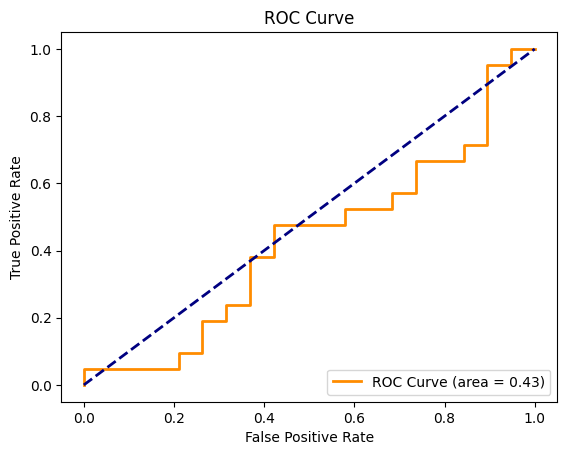

In [21]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Set up device
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

# Load datasets
train_df = pd.read_csv("medical_tc_train.csv")  # Adjust file name if necessary
test_df = pd.read_csv("medical_tc_test.csv")    # Adjust file name if necessary

train_texts = train_df["medical_abstract"][:100].tolist()
test_texts = test_df["medical_abstract"][:100].tolist()

# Function to calculate perplexity
def calculate_perplexity(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Function to calculate prediction confidence
def calculate_prediction_confidence(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        return probabilities.max().item()

# Function to calculate entropy
def calculate_entropy(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        return entropy(probabilities.cpu().numpy().flatten())

# Function to calculate feature representation distance
def calculate_feature_representation_distance(model, tokenizer, text, centroid, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        #embeddings = model.transformer.wte(input_ids).mean(dim=1).cpu().numpy()
        #embeddings = model.model.embed_tokens(input_ids).mean(dim=1).cpu().numpy()
        embedding_layer = model.get_input_embeddings()  # Get the embedding layer
        embeddings = embedding_layer(input_ids).mean(dim=1).cpu().numpy()
    return np.linalg.norm(embeddings - centroid)

# Calculate centroid for training set embeddings
def calculate_centroid(model, tokenizer, texts, device):
    embeddings = []
    for text in texts:
        input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
        with torch.no_grad():
            #embedding = model.transformer.wte(input_ids).mean(dim=1).cpu().numpy()
            #embedding = model.model.embed_tokens(input_ids).mean(dim=1).cpu().numpy()
            embedding_layer = model.get_input_embeddings()  # Get the embedding layer
            embedding = embedding_layer(input_ids).mean(dim=1).cpu().numpy()
        embeddings.append(embedding)
    return np.mean(embeddings, axis=0)

# Calculate centroid for training texts
train_centroid = calculate_centroid(generator_model, tokenizer, train_texts, device)
test_centroid = calculate_centroid(generator_model, tokenizer, test_texts, device)

# Calculate features for training and test texts
def calculate_features(model, tokenizer, texts, centroid, device):
    perplexities, confidences, entropies, frd_distances = [], [], [], []
    for text in texts:
        perplexities.append(calculate_perplexity(model, tokenizer, text, device))
        confidences.append(calculate_prediction_confidence(model, tokenizer, text, device))
        entropies.append(calculate_entropy(model, tokenizer, text, device))
        frd_distances.append(calculate_feature_representation_distance(model, tokenizer, text, centroid, device))
    return perplexities, confidences, entropies, frd_distances

train_features = calculate_features(generator_model, tokenizer, train_texts, train_centroid, device)
test_features = calculate_features(generator_model, tokenizer, test_texts, test_centroid, device)

# Combine features and labels
train_labels = [1] * len(train_texts)  # Members
test_labels = [0] * len(test_texts)    # Non-members

combined_features = np.vstack((
    np.column_stack(train_features),
    np.column_stack(test_features)
))
combined_labels = np.array(train_labels + test_labels)

# Normalize features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(combined_features)

# Split data for training the attack model
X_train, X_test, y_train, y_test = train_test_split(normalized_features, combined_labels, test_size=0.2, random_state=42)

# Train LightGBM attack model
clf = LGBMClassifier(class_weight="balanced", learning_rate=0.1, n_estimators=100)
clf.fit(X_train, y_train)

# Evaluate the attack model
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [11]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import csv

# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load datasets
train_df = pd.read_csv("medical_tc_train.csv")  # Adjust file name if necessary
test_df = pd.read_csv("medical_tc_test.csv")    # Adjust file name if necessary

train_texts = train_df["medical_abstract"][:200].tolist()
test_texts = test_df["medical_abstract"][:200].tolist()

def generate_long_text(model, tokenizer, prompt, max_length=300):    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text

# Function to calculate perplexity
def calculate_perplexity(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Function to calculate prediction confidence
def calculate_prediction_confidence(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        return probabilities.max().item()

# Function to calculate entropy
def calculate_entropy(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        return entropy(probabilities.cpu().numpy().flatten())

# Function to calculate feature representation distance
def calculate_feature_representation_distance(model, tokenizer, text, centroid, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        embeddings = model.model.embed_tokens(input_ids).mean(dim=1).cpu().numpy()
    return np.linalg.norm(embeddings - centroid)

# Calculate centroid for training set embeddings
def calculate_centroid(model, tokenizer, texts, device):
    embeddings = []
    for text in texts:
        input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
        with torch.no_grad():
            embedding = model.model.embed_tokens(input_ids).mean(dim=1).cpu().numpy()
        embeddings.append(embedding)
    return np.mean(embeddings, axis=0)

# Calculate centroid for training texts
train_centroid = calculate_centroid(generator_model, tokenizer, train_texts, device)
test_centroid = calculate_centroid(generator_model, tokenizer, test_texts, device)

# Calculate features for training and test texts
def calculate_features(model, tokenizer, texts, centroid, device):
    perplexities, confidences, entropies, frd_distances = [], [], [], []
    for text in texts:
        prompt = ' '.join(str(text).split()[:50])
        #print(prompt)
        text = generate_long_text(model, tokenizer, prompt, max_length=300)
        perplexities.append(calculate_perplexity(model, tokenizer, text, device))
        confidences.append(calculate_prediction_confidence(model, tokenizer, text, device))
        entropies.append(calculate_entropy(model, tokenizer, text, device))
        frd_distances.append(calculate_feature_representation_distance(model, tokenizer, text, centroid, device))
    return perplexities, confidences, entropies, frd_distances

# Open CSV file to store results
csv_filename = "lora_dp_high_med_txt_llm32_attack_model_results_new.csv"
with open(csv_filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Run", "Precision", "Recall", "F1-Score", "ROC-AUC"])

    for run in range(1, 11):  # Run 10 times
        print(f"Run {run}...")
        train_features = calculate_features(generator_model, tokenizer, train_texts, train_centroid, device)
        test_features = calculate_features(generator_model, tokenizer, test_texts, test_centroid, device)
    
        # Combine features and labels
        train_labels = [1] * len(train_texts)  # Members
        test_labels = [0] * len(test_texts)    # Non-members
    
        combined_features = np.vstack((
            np.column_stack(train_features),
            np.column_stack(test_features)
        ))
        combined_labels = np.array(train_labels + test_labels)
        # Normalize features
        scaler = MinMaxScaler()
        normalized_features = scaler.fit_transform(combined_features)      
        
        # Split data for training the attack model
        X_train, X_test, y_train, y_test = train_test_split(normalized_features, combined_labels, test_size=0.2, random_state=42 + run)

        # Train LightGBM attack model
        clf = LGBMClassifier(class_weight="balanced", learning_rate=0.1, n_estimators=100)
        clf.fit(X_train, y_train)

        # Evaluate the attack model
        y_pred = clf.predict(X_test)
        y_pred_prob = clf.predict_proba(X_test)[:, 1]

        report = classification_report(y_test, y_pred, output_dict=True)
        precision = report["macro avg"]["precision"]
        recall = report["macro avg"]["recall"]
        f1_score = report["macro avg"]["f1-score"]
        roc_auc = roc_auc_score(y_test, y_pred_prob)

        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}, ROC-AUC: {roc_auc:.4f}")

        # Save to CSV
        writer.writerow([run, precision, recall, f1_score, roc_auc])

print(f"Results saved to {csv_filename}")


Run 1...
[LightGBM] [Info] Number of positive: 165, number of negative: 155
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


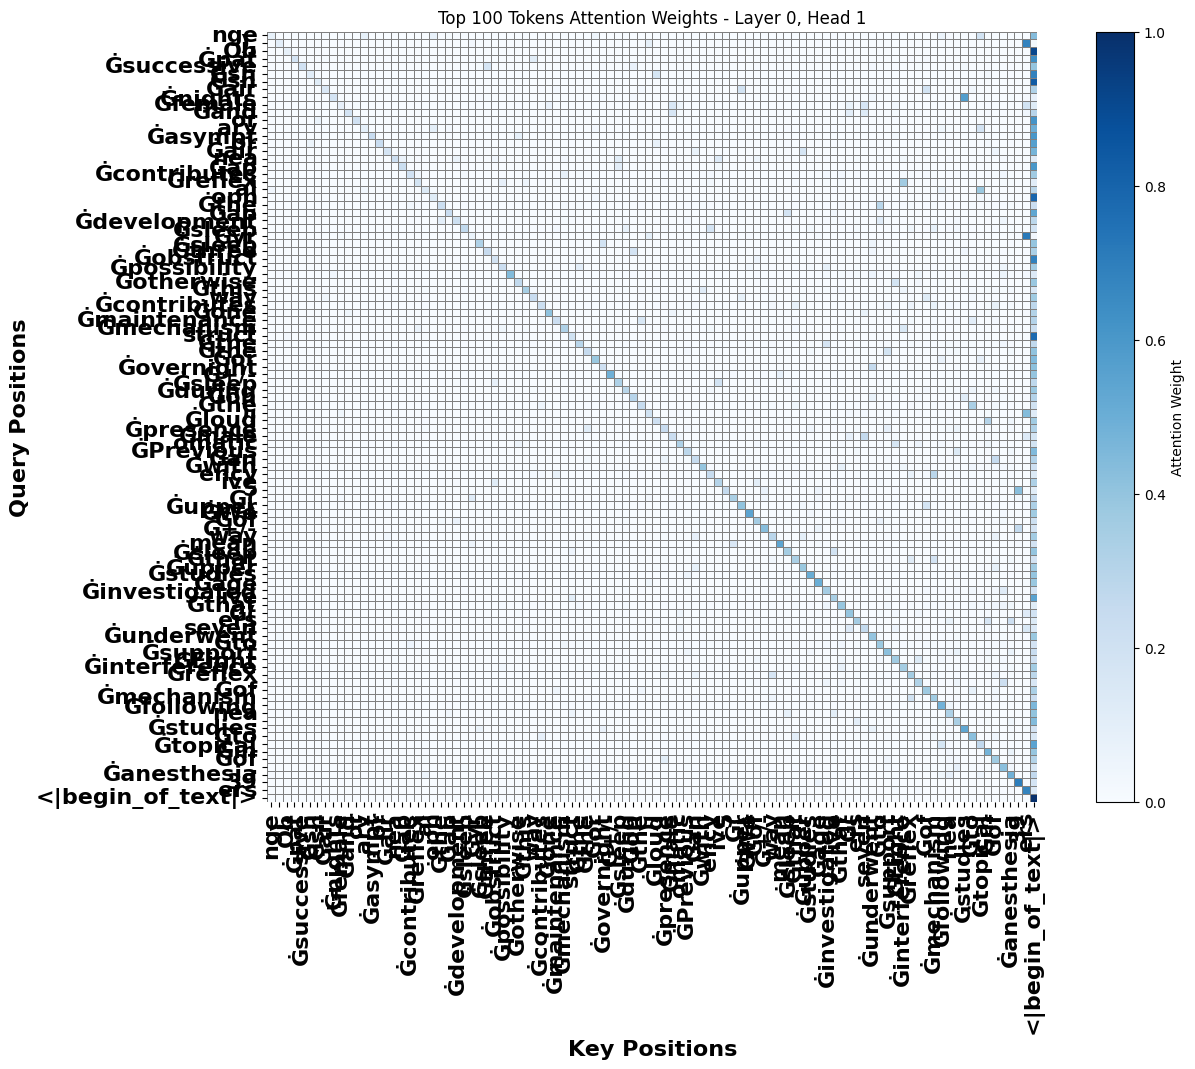

In [6]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
def visualize_attention(model, tokenizer, text, layer_idx=-1, head_idx=0, top_n_tokens=150, filename="attention_heatmap.jpg"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions
    attention_matrix = attentions[layer_idx][0, head_idx].cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    avg_attention = attention_matrix.mean(axis=0)
    top_indices = np.argsort(avg_attention)[-top_n_tokens:]
    top_tokens = [tokens[i] for i in top_indices]
    top_attention_matrix = attention_matrix[np.ix_(top_indices, top_indices)]
    df = pd.DataFrame(top_attention_matrix, index=top_tokens, columns=top_tokens)
    df.to_csv("lora_dp_med_txt_llm32_top_attention_matrix.csv")
    plt.figure(figsize=(15, 10))
    # Create the heatmap and store the result (QuadMesh object)
    heatmap = sns.heatmap(
        top_attention_matrix,
        cmap="Blues",
        linewidths=0.5,
        linecolor="gray",
        square=True,
        cbar=False,
        vmin=0, vmax=1,
        xticklabels=top_tokens, yticklabels=top_tokens
    )
    plt.xticks(rotation=90, fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')
    plt.xlabel("Key Positions", fontsize=16, fontweight='bold')
    plt.ylabel("Query Positions", fontsize=16, fontweight='bold')
    plt.title(f"Top {top_n_tokens} Tokens Attention Weights - Layer {layer_idx+1}, Head {head_idx+1}")
    plt.colorbar(heatmap.collections[0], label="Attention Weight") # Pass the QuadMesh object to colorbar

    plt.savefig(filename)
    plt.show()
text = "Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep. We investigated the possibility that interference with this reflex mechanism contributes to the development of obstructive sleep apnea. Eight otherwise asymptomatic snorers (seven male and one female), age 39 +/- 5.3 yr (mean +/- SEM), underwent overnight sleep studies on three successive nights."
# Example usage
visualize_attention(generator_model, tokenizer, text, layer_idx=-1, head_idx=0, top_n_tokens=100, filename="fi_lora_dp_high_med_txt_gen_attn_map.jpg")
